In [16]:
%load_ext autoreload
%autoreload 2

In [17]:
!nvidia-smi

Wed Mar  5 16:05:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.04             Driver Version: 570.124.04     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5000               Off |   00000000:01:00.0 Off |                  Off |
| 30%   27C    P8              8W /  230W |    2597MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [18]:
import os

if 'notebooks' in os.getcwd():
    os.chdir("..")

import evaluate
from datasets import load_dataset, Dataset
from huggingface_hub import notebook_login
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import time
import csv
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from trl import SFTTrainer, SFTConfig
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported
from unsloth.chat_templates import train_on_responses_only, get_chat_template
import aiohttp
import asyncio
from tqdm.asyncio import tqdm
import torch
import scienceplots
plt.style.use(['science', 'no-latex'])
from IPython.display import clear_output
from src.pytorch_utils import count_parameters
from src.text_utils import trim_text_to_token_limit
from src.train_test_split import stratified_train_test_split
from unsloth import FastLanguageModel


tqdm.pandas()

In [19]:
notebook_login()

In [20]:
torch.cuda.set_per_process_memory_fraction(0.6, device=0)


# Supervised Fine Tuning (SFT)

In this notebook we will finetune our Small Language Model on the target completions

## Loading base model

In [21]:
max_seq_length = 6000
dtype = None 
load_in_4bit = True

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen2-0.5B-Instruct", # or choose "unsloth/Llama-3.2-1B-Instruct"
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    cache_dir = '/Data'
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

==((====))==  Unsloth 2025.2.15: Fast Qwen2 patching. Transformers: 4.49.0.
   \\   /|    GPU: NVIDIA RTX A5000. Max memory: 23.536 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


## Using LoRA adapters

In [22]:
lora_rank = 32 
model = FastLanguageModel.get_peft_model(
    model,
    r = lora_rank, 
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 2 * lora_rank,
    lora_dropout = 0.05, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.05.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2025.2.15 patched 24 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


In [23]:
count_parameters(model)

Total Parameters: 332,715,904 
Trainable Parameters: 17,596,416 (5.0 %)


## Loading dataset

In [24]:
base_data = pd.read_json("data/wikipedia_dataset.json")
completions_df = pd.read_pickle("data/generated_dataset_100_Meta-Llama-3.1-8B-Instruct-bnb-4bit_2.pkl")

In [25]:
text_df = pd.merge(
    base_data,
    completions_df,
    on = 'id'
)[['id', 'text', 'num_tokens', 'generated_text']]

In [26]:
text_df.head()

,id,text,num_tokens,generated_text
0,9513,"Conhecimento (do latim cognoscere, ""ato de con...",1785,"O conhecimento é o ato ou efeito de conhecer, ..."
1,1337,"O nazismo (), oficialmente nacional-socialismo...",2864,O nazismo é uma ideologia associada a Adolf Hi...
2,1718,Sergipe é uma das 27 unidades federativas do B...,3041,Sergipe é um estado brasileiro localizado na R...
3,3832,Suíça ( ; em suíço-alemão: Schwyz ou Schwiiz ;...,674,A Suíça é uma república federal composta por 2...
4,302,"Aristóteles (; Estagira, – Atenas, ) foi um f...",2666,Aristóteles foi um filósofo e polímata da Gréc...


### Train test split

We will perform a stratified train-test split, maintaining the distribution of number of tokens     

In [27]:
train_df , temp = stratified_train_test_split(text_df, test_size=0.4)
test_df, val_df = stratified_train_test_split(temp, test_size=0.5)

Text(0.5, 0, 'Number of tokens')

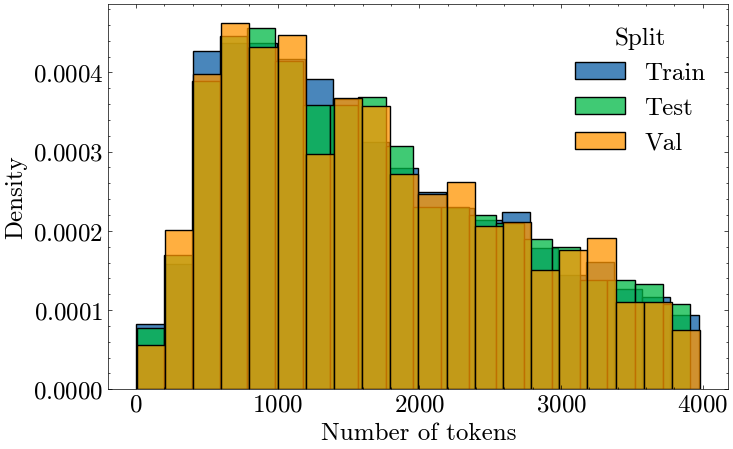

In [30]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize = (8,5))

sns.histplot(train_df, x = 'num_tokens', stat = 'density', bins = 20, label = 'Train')
sns.histplot(test_df, x = 'num_tokens', stat='density', bins = 20, label = 'Test')
sns.histplot(val_df, x = 'num_tokens', stat='density', bins = 20, label = 'Val')

plt.legend(title = 'Split')
plt.xlabel("Number of tokens")

## Finetuning

In [14]:
from datasets import Dataset

In [15]:
n_words = 100

In [16]:
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "qwen-2.5",
)

def format_row(row):
    prompt = f'''
        Você é um assistente virtual que deve gerar resumos de textos em português. 
        Seu resumo deve ter, no máximo {n_words} palavras e conter todas as informações principais do texto.
        Esse é o texto:

        {row['text']}
        
        Faça um resumo de no máximo {n_words} palavras do texto acima.
    '''

    row['conversations'] = [{'role': 'user', "content": prompt}, {'role': 'assistant', 'content': row['generated_text']}]
    return row


def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    return { "text" : texts, }

def generate_and_tokenize_prompt(text):
    # Generate the full prompt with the assistant's response
    tokenized_full_prompt = tokenizer(text, return_tensors='pt')

    # Clone the input_ids to create labels
    labels = tokenized_full_prompt.input_ids.clone()

    # Find the position of "<assistant>" in the prompt
    prompt_text = text[:text.find(">assistant")] + ">assistant"
    end_prompt_idx = len(tokenizer(prompt_text, return_tensors="pt")["input_ids"][0])

    # Mask all tokens before "<assistant>" with -100
    labels[:, :end_prompt_idx] = -100
    # labels = labels[:, end_prompt_idx:]

    return {
        'input_ids': tokenized_full_prompt.input_ids.flatten(),
        'labels': labels.flatten(),
        'attention_mask': tokenized_full_prompt.attention_mask.flatten(),
    }

def preprocess_df(df):
    temp_df = df.progress_apply(format_row, axis =1)
    temp_df = formatting_prompts_func(temp_df)

    tokens = []
    for t in tqdm(temp_df['text']):
        tokens.append(generate_and_tokenize_prompt(t))

    
    tokens_dataset = Dataset.from_list(tokens)
    return tokens_dataset

In [17]:
train_dataset = preprocess_df(train_df)
val_dataset = preprocess_df(val_df)
test_dataset = preprocess_df(test_df)

100%|██████████| 1000/1000 [00:06<00:00, 150.24it/s]


In [18]:
trainer = SFTTrainer(
    model = model,
    train_dataset = train_dataset,
    eval_dataset= val_dataset,
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    # compute_metrics = compute_metrics,
    args = SFTConfig(
        # eval_strategy = 'steps',
        # eval_steps = 1,
        per_device_train_batch_size = 16,
        gradient_accumulation_steps = 4,
        dataset_num_proc = 2,
        packing = False, # Can make training 5x faster for short sequences.
        warmup_steps = 5,
        num_train_epochs = 1, # Set this for 1 full training run.
        learning_rate = 2e-5,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        hub_model_id= "peulsilva/slm-pt",
        save_total_limit=1,
        # output_dir = "/Data",
        # report_to = "none", # Use this for WandB etc,
        # push_to_hub=True,
        # save_steps = 10,
        # hub_strategy="every_save",
        max_seq_length = max_seq_length,
        # dataset_text_field = 'text',
        batch_eval_metrics = True,
        # padding = True,
    ),
)



In [19]:
n_epochs = 5
for epoch in range(n_epochs):
    trainer.train()
    trainer.model.push_to_hub_merged(f"peulsilva/qwen-0.5b-instruct-summary-pt-checkpoint{epoch}")
    trainer.tokenizer.push_to_hub(f"peulsilva/qwen-0.5b-instruct-summary-pt-checkpoint{epoch}")

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 3,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 16 | Gradient Accumulation steps = 4
\        /    Total batch size = 64 | Total steps = 47
 "-____-"     Number of trainable parameters = 17,596,416


Step,Training Loss
1,1.103000
2,1.128900
3,1.128000
4,1.125700
5,1.030200
6,1.064800
7,0.981700
8,0.907600
9,0.889400
10,0.846100


Unsloth: You're not saving a tokenizer as well?
You can do it separately via `tokenizer.push_to_hub(...)`
Unsloth: You are pushing to hub, but you passed your HF username = peulsilva.
We shall truncate peulsilva/qwen-0.5b-instruct-summary-pt-checkpoint0 to qwen-0.5b-instruct-summary-pt-checkpoint0


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 34.41 out of 62.29 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 24/24 [00:00<00:00, 168.51it/s]


model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Done.
Saved merged model to https://huggingface.co/peulsilva/qwen-0.5b-instruct-summary-pt-checkpoint0


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
No files have been modified since last commit. Skipping to prevent empty commit.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 3,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 16 | Gradient Accumulation steps = 4
\        /    Total batch size = 64 | Total steps = 47
 "-____-"     Number of trainable parameters = 17,596,416


Step,Training Loss
1,0.656700
2,0.691800
3,0.684500
4,0.671200
5,0.642000
6,0.717700
7,0.716000
8,0.669900
9,0.674900
10,0.681100


Unsloth: You are pushing to hub, but you passed your HF username = peulsilva.
We shall truncate peulsilva/qwen-0.5b-instruct-summary-pt-checkpoint1 to qwen-0.5b-instruct-summary-pt-checkpoint1


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 34.24 out of 62.29 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 24/24 [00:00<00:00, 240.29it/s]


README.md:   0%|          | 0.00/600 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Done.
Saved merged model to https://huggingface.co/peulsilva/qwen-0.5b-instruct-summary-pt-checkpoint1


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
No files have been modified since last commit. Skipping to prevent empty commit.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 3,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 16 | Gradient Accumulation steps = 4
\        /    Total batch size = 64 | Total steps = 47
 "-____-"     Number of trainable parameters = 17,596,416


Step,Training Loss
1,0.609800
2,0.643900
3,0.633900
4,0.619100
5,0.595800
6,0.669900
7,0.672700
8,0.624700
9,0.631400
10,0.644900


Unsloth: You are pushing to hub, but you passed your HF username = peulsilva.
We shall truncate peulsilva/qwen-0.5b-instruct-summary-pt-checkpoint2 to qwen-0.5b-instruct-summary-pt-checkpoint2


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 33.72 out of 62.29 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 24/24 [00:00<00:00, 233.84it/s]


README.md:   0%|          | 0.00/600 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Done.
Saved merged model to https://huggingface.co/peulsilva/qwen-0.5b-instruct-summary-pt-checkpoint2


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
No files have been modified since last commit. Skipping to prevent empty commit.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 3,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 16 | Gradient Accumulation steps = 4
\        /    Total batch size = 64 | Total steps = 47
 "-____-"     Number of trainable parameters = 17,596,416


Step,Training Loss
1,0.581500
2,0.615300
3,0.603600
4,0.586700
5,0.565200
6,0.637200
7,0.643000
8,0.593400
9,0.603300
10,0.618000


Unsloth: You are pushing to hub, but you passed your HF username = peulsilva.
We shall truncate peulsilva/qwen-0.5b-instruct-summary-pt-checkpoint3 to qwen-0.5b-instruct-summary-pt-checkpoint3


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 33.81 out of 62.29 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 24/24 [00:00<00:00, 235.59it/s]


README.md:   0%|          | 0.00/594 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Done.
Saved merged model to https://huggingface.co/peulsilva/qwen-0.5b-instruct-summary-pt-checkpoint3


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


README.md:   0%|          | 0.00/600 [00:00<?, ?B/s]

KeyboardInterrupt: 

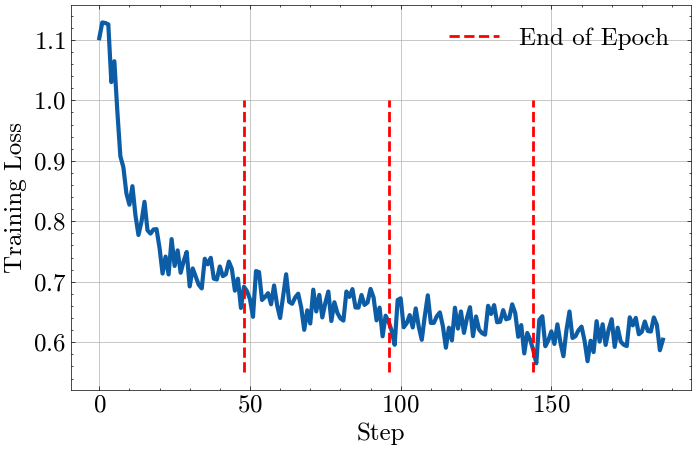

In [14]:
plt.rcParams.update({'font.size': 18})
# Concatenated training loss data from all steps
steps = list(range(1, 48)) * 4  # Repeating steps for 4 epochs
training_losses = [
    1.103000, 1.128900, 1.128000, 1.125700, 1.030200, 1.064800, 0.981700, 0.907600, 0.889400, 0.846100,
    0.827500, 0.858100, 0.810000, 0.777400, 0.799200, 0.832300, 0.785100, 0.779700, 0.786500, 0.787100,
    0.755900, 0.713600, 0.741600, 0.712100, 0.770600, 0.726200, 0.751900, 0.714900, 0.734100, 0.749300,
    0.692300, 0.722100, 0.708500, 0.695000, 0.689000, 0.738100, 0.728900, 0.739600, 0.705200, 0.703700,
    0.725300, 0.709300, 0.712500, 0.733400, 0.721000, 0.685300, 0.705100,

    0.656700, 0.691800, 0.684500, 0.671200, 0.642000, 0.717700, 0.716000, 0.669900, 0.674900, 0.681100,
    0.662800, 0.693900, 0.661500, 0.640100, 0.676500, 0.712400, 0.666800, 0.663600, 0.674100, 0.680300,
    0.657400, 0.620500, 0.652700, 0.631000, 0.686900, 0.650900, 0.678300, 0.641000, 0.665000, 0.683800,
    0.635100, 0.666100, 0.648500, 0.639500, 0.635800, 0.683900, 0.675000, 0.687900, 0.657500, 0.657300,
    0.678100, 0.661700, 0.665600, 0.688200, 0.674200, 0.636200, 0.657200,

    0.609800, 0.643900, 0.633900, 0.619100, 0.595800, 0.669900, 0.672700, 0.624700, 0.631400, 0.644900,
    0.624400, 0.655900, 0.625600, 0.604000, 0.643200, 0.677600, 0.631900, 0.632000, 0.643000, 0.649300,
    0.626600, 0.590900, 0.624000, 0.603100, 0.657100, 0.622600, 0.650900, 0.615500, 0.640100, 0.657900,
    0.610100, 0.642600, 0.620900, 0.615100, 0.612500, 0.660300, 0.646700, 0.661400, 0.633000, 0.633800,
    0.653100, 0.637900, 0.639600, 0.662700, 0.648300, 0.609000, 0.628300,

    0.581500, 0.615300, 0.603600, 0.586700, 0.565200, 0.637200, 0.643000, 0.593400, 0.603300, 0.618000,
    0.597200, 0.629600, 0.599400, 0.576900, 0.620100, 0.650800, 0.607000, 0.610000, 0.619900, 0.625800,
    0.602900, 0.568600, 0.602500, 0.583700, 0.634800, 0.601000, 0.629700, 0.595500, 0.620800, 0.638000,
    0.592300, 0.624000, 0.601100, 0.595900, 0.593600, 0.641200, 0.627900, 0.640300, 0.613200, 0.617100,
    0.634300, 0.618600, 0.617700, 0.641000, 0.628800, 0.586800, 0.604100,
]

# Plot the training loss
plt.figure(figsize=(8, 5))
plt.plot(training_losses, linewidth=3)
plt.vlines(
    [k * 48 for k in range(1,4)], 
    ymin= 0.55, 
        ymax=1.0, 
    linestyles='dashed', 
    colors='red', 
    label='End of Epoch',
    linewidth = 2    
)
plt.xlabel("Step")
plt.ylabel("Training Loss")
plt.legend()
plt.grid(True)
plt.show()